# Readme(Important!!)

Please also put the folder 'new_features' under the directory

In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import keras
from keras import models
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import glob
from keras.layers import Reshape

# Data Preperation

In [131]:
def processing_data(df,targetdf):
#     this is the method used to pre-process data. the main idea is to process values of each features 
#     for 5,7,9,...,79 different altitudes.
#     and create a new feature csv file in shape(38,10) 

    radius =  3397200 + (targetdf[:,0]*1000)
    radius_col = df[:,1]
    new = pd.DataFrame([])
    new = pd.concat((new,pd.DataFrame(targetdf[:,0])), axis=1)
    for i in range(9):
        y =  df[:,i+2]
        intersections = pd.DataFrame(np.interp(radius, radius_col[::-1], y[::-1]))
#         map values for altitudes
        new = pd.concat((new,intersections[::-1]), axis=1)
    new = new.reset_index(drop=True)
    new.columns = [np.arange(0,new.shape[1])]
    return new


In [133]:
filenames = glob.glob('features/*.csv')
count = 0
# process all the feature files to create 1000 new feature files in name: new features
mytarget = np.genfromtxt('targets/target_0001.csv',delimiter=',')
for files in filenames:
    count += 1;
    myfeature = np.genfromtxt(files,delimiter=',');
    aa = processing_data(myfeature,mytarget)
    aa.to_csv("new_features/new_features{0000}.csv".format(count),index=False,header=False)
    

In [63]:
def Combine_Dataset(max,filenames,size):
#     this method is to combine all the feature files or target files in a 3d array, first index is the index of file
#     output_array[file_index][row_index][column_index]
    cnt = 0;
    output_array = np.zeros((max,38,size), dtype=np.float32)
    for files in filenames:
        myfeature = np.genfromtxt(files,delimiter=',');
        output_array[cnt] = myfeature;
        cnt += 1;
        if(cnt >= max):
            return output_array;
    return output_array


In [ ]:
#split the feature and target dataset into 3 parts: 
# 800train, 100test, 100valid
features = Combine_Dataset(1000,glob.glob('new_features/*.csv'),10)
targets = Combine_Dataset(1000,glob.glob('targets/*.csv'),4)

train_features, test_features = features[100:], features[:100]
train_features, valid_features = train_features[100:], train_features[:100]

train_targets, test_targets = targets[100:], targets[:100]
train_targets, valid_targets = train_targets[100:], train_targets[:100]

# Building the model

In [119]:
# build LSTM model for learning
# outputdim for first layer is 256,input shape is (38,10)
model = Sequential()
model.add(LSTM(256,input_shape=(38,10),return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences = True))
model.add(LSTM(128, return_sequences = True))
model.add(LSTM(128, return_sequences = True))
model.add(LSTM(64, return_sequences = True))

# model.add(LSTM(38, return_sequences = True))
model.add(Dropout(0.2))
# model.add(LSTM(units = 64, return_sequences = False))
model.add(Dense(4))


model.compile(optimizer = 'adam', loss = 'mse',metrics = ['mse'])
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_65 (LSTM)               (None, 38, 256)           273408    
_________________________________________________________________
dropout_26 (Dropout)         (None, 38, 256)           0         
_________________________________________________________________
lstm_66 (LSTM)               (None, 38, 128)           197120    
_________________________________________________________________
lstm_67 (LSTM)               (None, 38, 128)           131584    
_________________________________________________________________
lstm_68 (LSTM)               (None, 38, 128)           131584    
_________________________________________________________________
lstm_69 (LSTM)               (None, 38, 64)            49408     
_________________________________________________________________
dropout_27 (Dropout)         (None, 38, 64)          

# TRAINING

In [120]:
#feed data to the LSTM,
history = model.fit(train_features,train_targets,batch_size=10,validation_data=(valid_features,valid_targets), epochs = 100)

Epoch 1/100
80/80 [==============================] - 10s 76ms/step - loss: 1326.1694 - mse: 1326.1693 - val_loss: 1062.8391 - val_mse: 1062.8391
Epoch 2/100
80/80 [==============================] - 5s 60ms/step - loss: 1062.7184 - mse: 1062.7187 - val_loss: 932.0852 - val_mse: 932.0854
Epoch 3/100
80/80 [==============================] - 5s 62ms/step - loss: 941.6414 - mse: 941.6415 - val_loss: 832.5050 - val_mse: 832.5049
Epoch 4/100
80/80 [==============================] - 5s 61ms/step - loss: 841.2733 - mse: 841.2734 - val_loss: 758.5745 - val_mse: 758.5745
Epoch 5/100
80/80 [==============================] - 5s 61ms/step - loss: 781.2918 - mse: 781.2918 - val_loss: 702.1830 - val_mse: 702.1830
Epoch 6/100
80/80 [==============================] - 5s 63ms/step - loss: 722.4054 - mse: 722.4054 - val_loss: 651.0735 - val_mse: 651.0735
Epoch 7/100
80/80 [==============================] - 5s 63ms/step - loss: 680.3062 - mse: 680.3063 - val_loss: 610.5486 - val_mse: 610.5487
Epoch 8/100
8

# Evaluation

Text(0.5, 0, 'epochs')

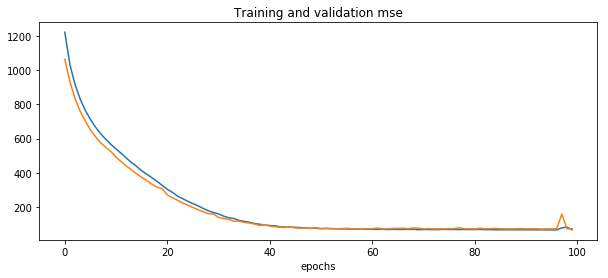

In [126]:
epochs = range(len(history.history['loss']))
f,fig=plt.subplots( figsize=(10,4))
# fig[0].plot  ( epochs,     history.history[     'loss' ], label='Training')
# fig[0].plot  ( epochs, history.history[     'val_loss' ], label='Validation')
# plt.title ('Training and validation loss')
# fig[0].legend()
# plt.xlabel('epochs')

fig.plot  ( epochs,     history.history[     'mse' ], label='Training')
fig.plot  ( epochs, history.history[     'val_mse' ], label='Validation')
# plt.legend()
plt.title ('Training and validation mse')
plt.xlabel('epochs')

In [129]:
#this code allows you to calculate final percentage error for one trajectory. 
#You can use it to iterate over whole testing dataset and average the final error over all trajectories in it
# model.save("LSTM_Model")
loaded = keras.models.load_model("LSTM_Model")

final_err= []
for i in range(100):
    xx=np.reshape(features[i],(-1,38,10))
    yy=np.reshape(targets[i],(-1,38,4))

    predictions= loaded.predict(xx)  #a 38x4 numpy array with predicted atmospehric conditions returned by your model
    ground_truth=yy  #a 38x4 numpy array from the target file corresponding to features used in the predictions

    diffwind=np.sqrt(np.square(predictions[:,3]-ground_truth[:,3])+np.square(predictions[:,2]-ground_truth[:,3])) #calculate vector difference in wind
    windvecGT=np.sqrt(np.square(ground_truth[:,3])+np.square(ground_truth[:,2])) #length of the ground_truth wind vector at each altitude

    #relative (percentage) errors for each altitude
    rel_err_d=100*(predictions[:,1]-ground_truth[:,1])/ground_truth[:,1]
    rel_err_w=100*(diffwind)/windvecGT

    #RMS percentage errors for the whole trajectory, density and wind separately
    RMS_d=np.sqrt(1/38*np.sum(np.square(rel_err_d)))
    RMS_w=np.sqrt(1/38*np.sum(np.square(rel_err_w)))
    final_err.append((RMS_d+RMS_w)/2)  #final error, average of all variables

final_err= np.mean(final_err)
print('density error: ',RMS_d,'%,\nwind error:', RMS_w, '% \nfinal_err=', final_err, '%')

# print(final_err)

density error:  6.138885852554256 %,
wind error: 4.145183919633779 % 
final_err= 7.2218773188980165 %


# Run the cell below, for one click prediction!!
it is a section that combines the functions above, for convinience only
## Before run the cell below, please make sure put the 'new_features' folder in the directory!

In [7]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import keras
from keras import models
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import glob
from keras.layers import Reshape

def Combine_Dataset(max,filenames,size):
#     this method is to combine all the feature files or target files in a 3d array, first index is the index of file
#     output_array[file_index][row_index][column_index]
    cnt = 0;
    output_array = np.zeros((max,38,size), dtype=np.float32)
    for files in filenames:
        myfeature = np.genfromtxt(files,delimiter=',');
        output_array[cnt] = myfeature;
        cnt += 1;
        if(cnt >= max):
            return output_array;
    return output_array
# data splitting
#split the feature and target dataset into 3 parts: 
# 800train, 100test, 100valid
features = Combine_Dataset(1000,glob.glob('new_features/*.csv'),10)
targets = Combine_Dataset(1000,glob.glob('targets/*.csv'),4)

train_features, test_features = features[100:], features[:100]
train_features, valid_features = train_features[100:], train_features[:100]

train_targets, test_targets = targets[100:], targets[:100]
train_targets, valid_targets = train_targets[100:], train_targets[:100]

loaded = keras.models.load_model("LSTM_Model")

final_err= []
for i in range(100):
    xx=np.reshape(features[i],(-1,38,10))
    yy=np.reshape(targets[i],(-1,38,4))

    predictions= loaded.predict(xx)  #a 38x4 numpy array with predicted atmospehric conditions returned by your model
    ground_truth=yy  #a 38x4 numpy array from the target file corresponding to features used in the predictions

    diffwind=np.sqrt(np.square(predictions[:,3]-ground_truth[:,3])+np.square(predictions[:,2]-ground_truth[:,3])) #calculate vector difference in wind
    windvecGT=np.sqrt(np.square(ground_truth[:,3])+np.square(ground_truth[:,2])) #length of the ground_truth wind vector at each altitude

    #relative (percentage) errors for each altitude
    rel_err_d=100*(predictions[:,1]-ground_truth[:,1])/ground_truth[:,1]
    rel_err_w=100*(diffwind)/windvecGT

    #RMS percentage errors for the whole trajectory, density and wind separately
    RMS_d=np.sqrt(1/38*np.sum(np.square(rel_err_d)))
    RMS_w=np.sqrt(1/38*np.sum(np.square(rel_err_w)))
    final_err.append((RMS_d+RMS_w)/2)  #final error, average of all variables

final_err= np.mean(final_err)
print('density error: ',RMS_d,'%,\nwind error:', RMS_w, '% \nfinal_err=', final_err, '%')

# print(final_err)

density error:  6.138885852554256 %,
wind error: 4.145183919633779 % 
final_err= 7.2218773188980165 %
